In [824]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import Normalizer
import random
%matplotlib inline

In [825]:
args = {'lr':0.01,
        'train epochs':500,
        'hidden layers':10,
        'noise':0.01,
        'train size':0.7,
        'spec scale':10**12,
        'correlation':0,
        'input features': 30,
        'train criterion':nn.L1Loss(),
        'test criterion':nn.L1Loss(),
        'scaler':RobustScaler(),
        }

now = datetime.now()

Data Prep

In [826]:
layers = []
for i in range(1,12):
    layers.append({'layer':i,
                   'col': f'layer {i}'})

In [827]:
df = pd.read_excel('wide_range.xlsx')

In [828]:
X = df.iloc[:,11:]
y = df.iloc[:,:11]

In [829]:
# scale by 10^12
X = X.apply(lambda x: x*args['spec scale'])

In [830]:
scaler = args['scaler']
scaler.fit(X)
X_scaled = scaler.transform(X)


X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

Feature Selection

In [831]:
'''for layer in layers:
    inputs = X_scaled.copy()
    targets = y[layer['col']]

    rfe = RFE(estimator=LinearRegression(), n_features_to_select=args['num features'])

    rfe.fit(inputs, targets)

    selected_features = X.columns[rfe.support_]

    layer['features'] = selected_features

    print(f'Features for {layer["col"].capitalize()} ({len(selected_features)}):\n {selected_features}\n')
'''

for layer in layers:
    temp = X.copy()
    temp['layer'] = y[layer['col']]
    
    #features = temp.corr().abs()['layer'].sort_values(ascending=False).head(args['input features']+1).index[1:]
    
    corr_df = pd.DataFrame(temp.corr()['layer'].sort_values(ascending=False))
   
    features = []
    for index, row in corr_df.abs().iterrows():
        if index == 'layer':
            continue
        
        if row['layer'] > args['correlation']:
            features.append(index)
    
    layer['features'] = features

    print(f'Features for {layer["col"].capitalize()} ({len(features)}):\n {features}\n')


Features for Layer 1 (86):
 [3.95e-06, 4e-06, 3.9e-06, 4.05e-06, 3.85e-06, 3.8e-06, 4.1e-06, 3.75e-06, 4.15e-06, 4.2e-06, 4.25e-06, 4.3e-06, 4.55e-06, 4.6e-06, 4.5e-06, 4.45e-06, 4.35e-06, 4.4e-06, 4.65e-06, 4.7e-06, 4.75e-06, 4.8e-06, 4.85e-06, 4.9e-06, 4.95e-06, 5e-06, 5.05e-06, 5.1e-06, 5.15e-06, 5.2e-06, 6.15e-06, 6.1e-06, 6.2e-06, 6.05e-06, 6.25e-06, 5.25e-06, 6e-06, 5.95e-06, 6.3e-06, 5.9e-06, 5.85e-06, 6.35e-06, 5.3e-06, 5.8e-06, 5.75e-06, 6.4e-06, 5.7e-06, 5.35e-06, 5.65e-06, 6.45e-06, 5.4e-06, 5.6e-06, 5.45e-06, 5.55e-06, 5.5e-06, 6.5e-06, 6.55e-06, 6.6e-06, 6.65e-06, 6.7e-06, 6.75e-06, 6.8e-06, 6.85e-06, 6.9e-06, 6.95e-06, 7e-06, 7.05e-06, 8e-06, 7.95e-06, 7.1e-06, 7.9e-06, 7.85e-06, 7.15e-06, 7.8e-06, 7.75e-06, 7.2e-06, 7.25e-06, 7.7e-06, 7.3e-06, 7.35e-06, 7.65e-06, 7.4e-06, 7.6e-06, 7.45e-06, 7.55e-06, 7.5e-06]

Features for Layer 2 (86):
 [4.05e-06, 4e-06, 4.1e-06, 3.85e-06, 3.9e-06, 3.95e-06, 3.8e-06, 4.15e-06, 3.75e-06, 4.2e-06, 4.25e-06, 4.3e-06, 4.55e-06, 4.6e-06, 4.5

In [832]:
def add_noise(data, percentage):
    std_dev = percentage
    noise = np.random.normal(0, std_dev, data.shape)
    noisy_data = data + noise
    return noisy_data

In [833]:
# add noise
X_noisy = add_noise(X, args['noise'])

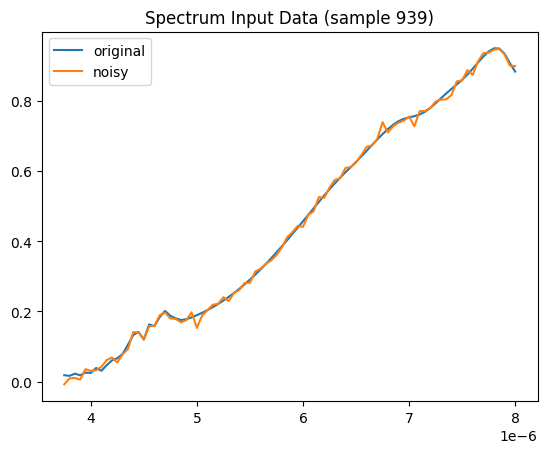

In [834]:
entry = random.randint(0, len(X))
plt.title(f'Spectrum Input Data (sample {entry})')
plt.plot(X.iloc[entry], label='original')
plt.plot(X_noisy.iloc[entry], label='noisy')
plt.legend()
plt.show()

In [835]:
scaler = args['scaler']
scaler.fit(X_noisy)
X_noisy_scaled = scaler.transform(X_noisy)

X_noisy_scaled_df = pd.DataFrame(X_noisy_scaled, columns=X.columns)

In [836]:
X_train, X_test, y_train, y_test = train_test_split(X_noisy_scaled_df, y, train_size=args['train size'], random_state=101)

In [837]:
for layer in layers:
    layer['y_train'] = torch.tensor(y_train[layer['col']].values, dtype=torch.float32).reshape(-1,1)
    layer['y_test'] = torch.tensor(y_test[layer['col']].values, dtype=torch.float32).reshape(-1,1)

    layer['X_train'] = torch.tensor(X_train[layer['features']].values, dtype=torch.float32)
    layer['X_test'] = torch.tensor(X_test[layer['features']].values, dtype=torch.float32)

In [838]:
class FeedForward(nn.Module):
    def __init__(self, input_size, output_size, num_hidden):
        super(FeedForward, self).__init__()
        
        hidden_sizes = [input_size]
        step = input_size / (num_hidden+1)

        for i in range(num_hidden):
            hidden_size = int(input_size - (i+1) * step)
            if hidden_size < 1: hidden_size = 1
            hidden_sizes.append(hidden_size)
        
        self.hidden_layers = nn.ModuleList()

        for i in range(num_hidden):
            self.hidden_layers.append(nn.Linear(hidden_sizes[i], hidden_sizes[i+1]))

        self.hidden_sizes = hidden_sizes
        self.lin_fin = nn.Linear(hidden_sizes[-1], output_size)

    def forward(self, x):
        for hidden_layer in self.hidden_layers:
            x = F.leaky_relu(hidden_layer(x))
        x = self.lin_fin(x)
        return x

In [839]:
criterion = args['train criterion']

In [840]:
for layer in layers:
    input = layer['X_train']
    target = layer['y_train']

    model = FeedForward(input.size()[1], target.size()[1], args['hidden layers'])

    best_loss = np.inf
    best_epoch = 0
    train_losses = []

    optimizer = torch.optim.Rprop(model.parameters(), lr=args['lr'])

    print(layer['col'])
    print(f'hidden layer sizes: {model.hidden_sizes}')

    for epoch in range(args['train epochs']):
        outputs = model(input)

        loss = criterion(outputs, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_losses.append(loss.item())
        
        if loss.item() < best_loss:
            best_loss = loss.item()
            best_epoch = epoch+1

        if (epoch+1) % int(args['train epochs']/10) == 0:
            print(f'epoch: {epoch+1}, loss = {loss}')

    layer['model'] = model
    layer['train losses'] = train_losses

    print(f'best loss: {best_loss} in epoch {best_epoch}\n')    

layer 1
hidden layer sizes: [86, 78, 70, 62, 54, 46, 39, 31, 23, 15, 7]


epoch: 50, loss = 11.521854400634766
epoch: 100, loss = 7.956563949584961
epoch: 150, loss = 7.569197654724121
epoch: 200, loss = 7.254308223724365
epoch: 250, loss = 7.096201419830322
epoch: 300, loss = 7.0040106773376465
epoch: 350, loss = 6.933454990386963
epoch: 400, loss = 6.856910705566406
epoch: 450, loss = 6.759319305419922
epoch: 500, loss = 6.727670192718506
best loss: 6.727670192718506 in epoch 500

layer 2
hidden layer sizes: [86, 78, 70, 62, 54, 46, 39, 31, 23, 15, 7]
epoch: 50, loss = 20.323883056640625
epoch: 100, loss = 9.207170486450195
epoch: 150, loss = 8.692811965942383
epoch: 200, loss = 8.404520988464355
epoch: 250, loss = 8.141854286193848
epoch: 300, loss = 7.9573469161987305
epoch: 350, loss = 7.789948463439941
epoch: 400, loss = 7.700900554656982
epoch: 450, loss = 7.632236003875732
epoch: 500, loss = 7.577996253967285
best loss: 7.577996253967285 in epoch 500

layer 3
hidden layer sizes: [86, 78, 70, 62, 54, 46, 39, 31, 23, 15, 7]
epoch: 50, loss = 23.3161964

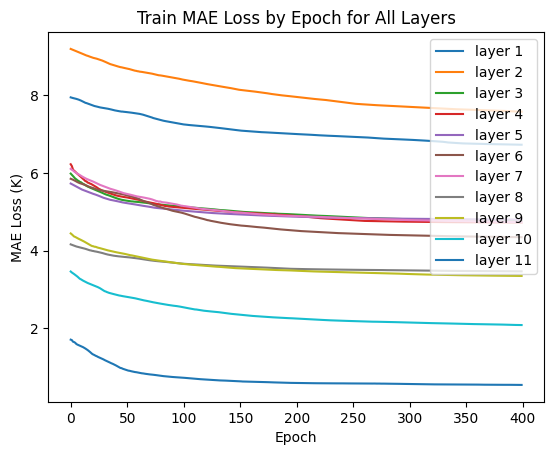

In [849]:
for layer in layers:
    plt.plot(layer['train losses'][100:], label=layer['col'])

    
plt.title(f"Train MAE Loss by Epoch for All Layers")
plt.xlabel("Epoch")
plt.ylabel("MAE Loss (K)")
plt.legend()
plt.show()

In [842]:
test_losses = []
test_criterion = args['test criterion']

for layer in layers:
    input = layer['X_test']
    target = layer['y_test']
    model = layer['model']

    with torch.no_grad():
        pred = model(input)
        loss = test_criterion(pred, target)
        test_losses.append(loss.item())

    y_test[f'{layer["col"]} predictions'] = pred.numpy()
    print(f'{layer["col"]} loss: {loss.item()}')

layer 1 loss: 7.458754062652588
layer 2 loss: 9.259740829467773
layer 3 loss: 5.555694580078125
layer 4 loss: 5.598252296447754
layer 5 loss: 5.229271411895752
layer 6 loss: 5.072845458984375
layer 7 loss: 5.77517032623291
layer 8 loss: 4.091972827911377
layer 9 loss: 4.349202632904053
layer 10 loss: 2.7851686477661133
layer 11 loss: 0.562541127204895


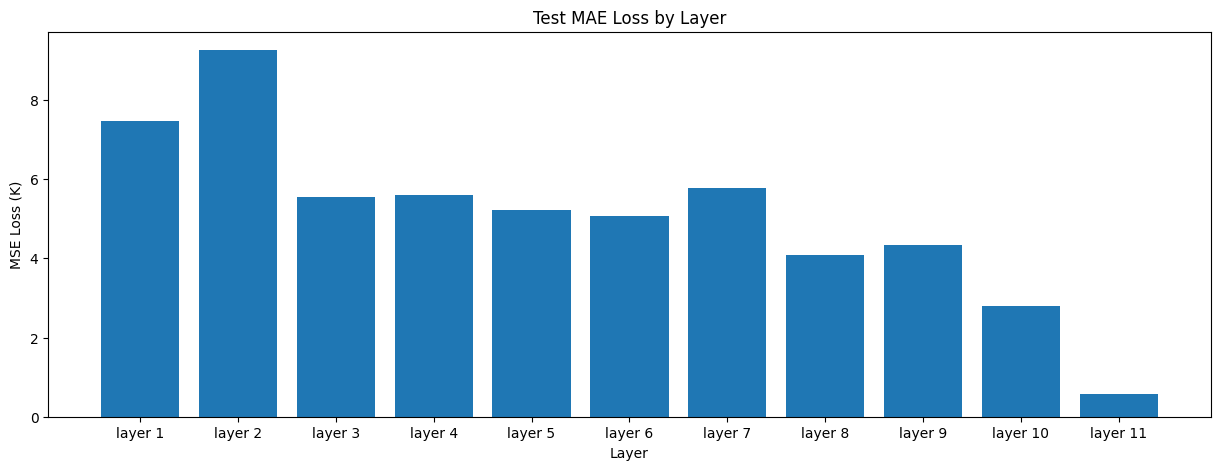

In [843]:
plt.figure(figsize=(15, 5))
plt.bar(y.columns, test_losses)

plt.title("Test MAE Loss by Layer")
plt.xlabel("Layer")
plt.ylabel("MSE Loss (K)")

plt.show()

In [844]:
def plot_comparison(pred, actual, sample):
    plt.figure(figsize=(15, 5))
    plt.title(f"Temperature Across Layers for Sample {sample}")
    plt.xlabel("Layer")
    plt.ylabel("Temperature (K)")
    plt.plot(pred, 'ro', label='predicted')
    plt.plot(actual, 'b', label='actual')
    plt.legend()
    plt.show()

In [845]:
actual_df = y_test.iloc[:, :11]
pred_df = y_test.iloc[:, 11:]
pred_df.columns = actual_df.columns

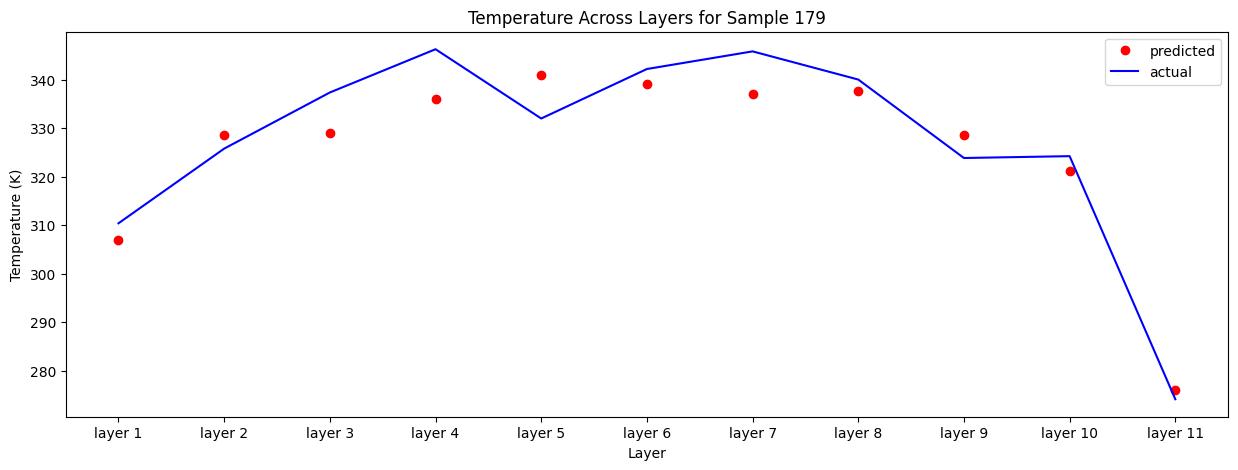

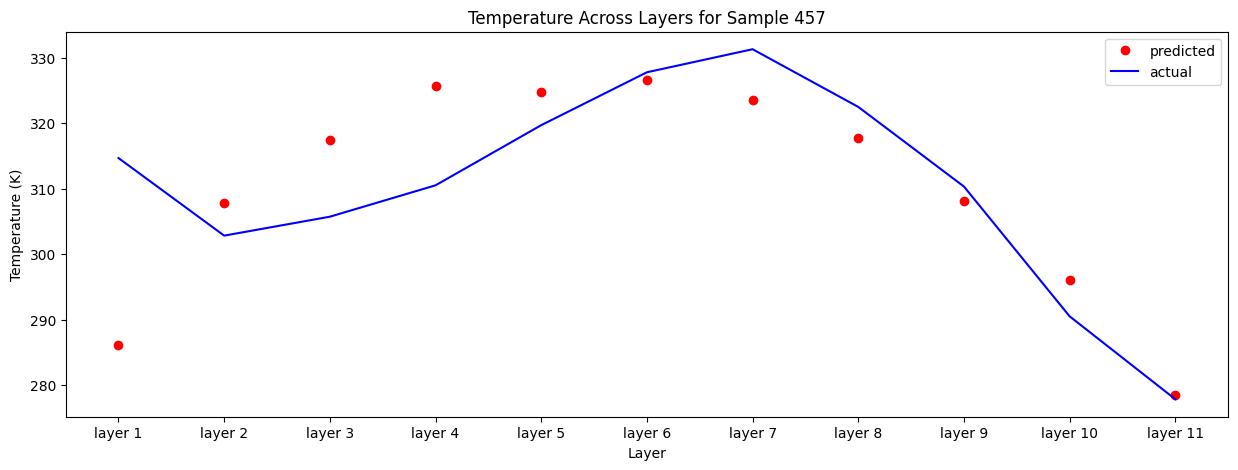

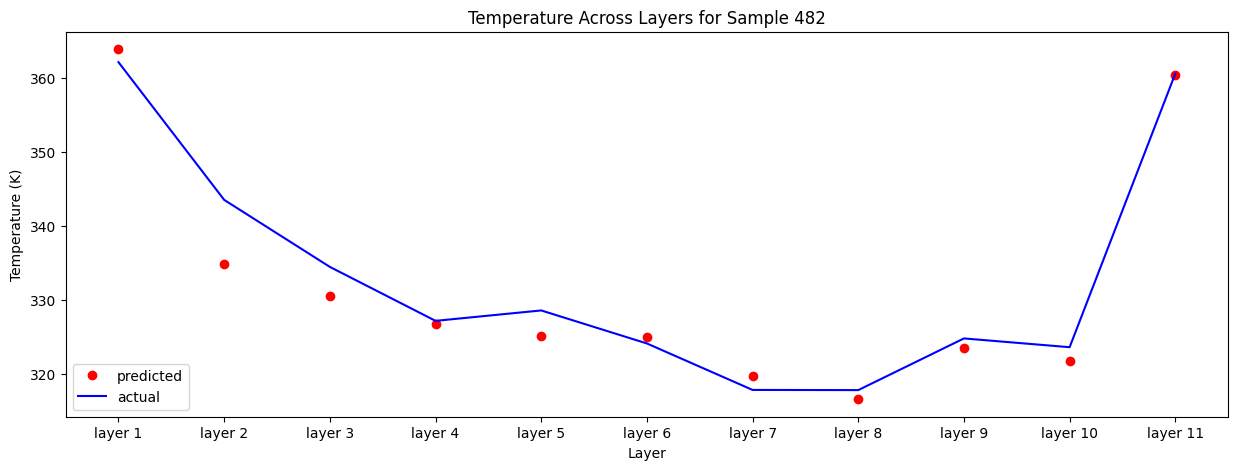

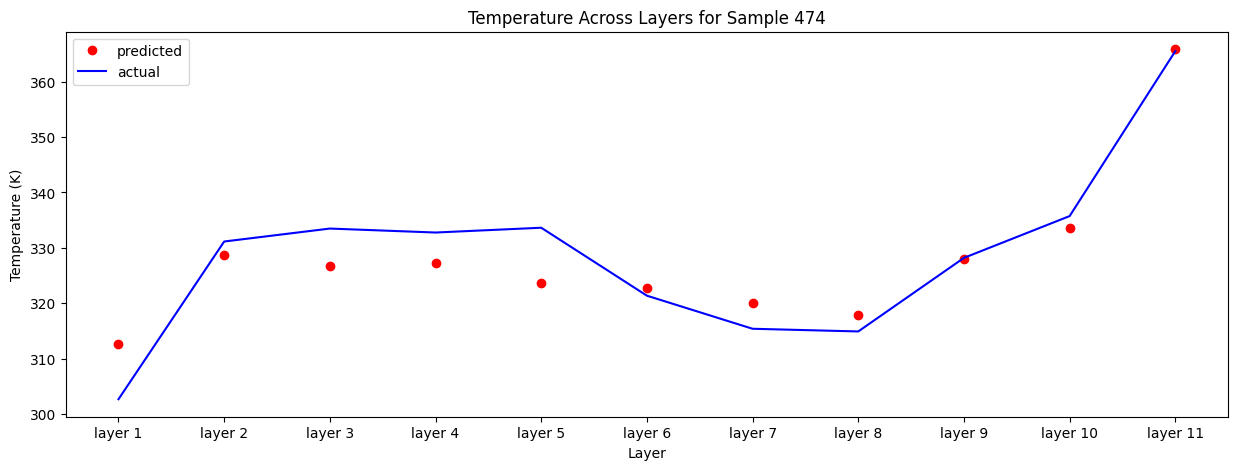

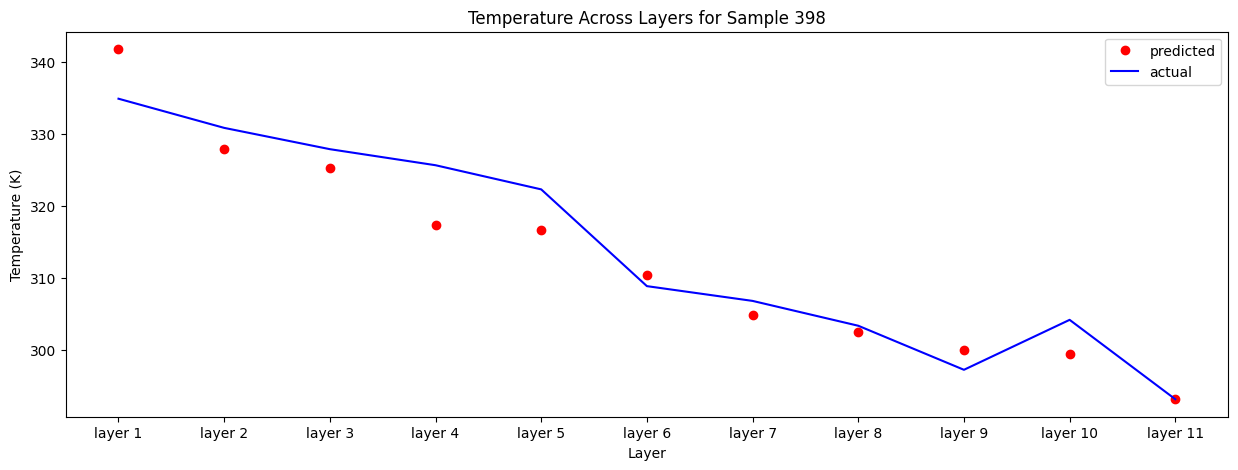

In [846]:
indices = []
for i in range(0,5):
    n = random.randint(0, len(y_test))
    indices.append(n)

for i in indices:
    actual = actual_df.iloc[i,:]
    pred = pred_df.iloc[i,:]

    plot_comparison(pred, actual, i)

In [847]:
with open('ff_one_layer_test.txt', "a") as f:
    f.write('===================================\n' +'|'.ljust(5) + f'{now.strftime("%m/%d/%Y, %H:%M:%S")}\n|\n')
    
    loss_str = ''
    for i in range(1, 12):
        loss_str += f'| layer {i} loss: '.ljust(20) + f'{test_losses[i-1]:.3f}\n'

    
    arg_str = ''
    for key in args:
        arg_str += f'| {key}:'.ljust(20) + f'{args[key]}\n'

    f.write('|'.ljust(10) + 'Losses\n' + f'|----------------------------------\n{loss_str}|\n'+ '|'.ljust(10) + 'Args' 
            + f'\n|----------------------------------\n{arg_str}====================================\n\n')